<a href="https://colab.research.google.com/github/vienskaz/COVID19-CNN/blob/main/COVID_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import of libraries**

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import pandas as pd
from PIL import Image
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading dataset**
all images are converted to grayscale

In [3]:
data_path = "/content/drive/MyDrive/Covid19-dataset"  # Adjust this to the actual path

test_data = []
test_labels = []
train_data = []
train_labels = []

class_names = ["Covid", "Normal", "Viral Pneumonia"]

for subset in ['test', 'train']:
    subset_data = []
    subset_labels = []
    subset_path = os.path.join(data_path, subset)

    for class_name in class_names:
        class_path = os.path.join(subset_path, class_name)

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = Image.open(image_path).convert('L')
            image = np.array(image)

            subset_data.append(image)
            subset_labels.append(class_name)

    if subset == 'test':
        test_data.extend(subset_data)
        test_labels.extend(subset_labels)
    else:
        train_data.extend(subset_data)
        train_labels.extend(subset_labels)

y_test = np.array(test_labels)
y_train = np.array(train_labels)


# **Normalization of all images to make the pixels value in range 0-1**
also all images are rezised to 400x400 pixels


In [4]:
def normalize(images, new_height=400, new_width=400):
    normalized = []
    for i in range(len(images)):
        resized_image = cv2.resize(images[i], (new_width, new_height))
        normalized_image = resized_image / 255.0
        normalized.append(normalized_image)
    ready_arr = np.asarray(normalized)
    return ready_arr



In [5]:
X_train=normalize(train_data)
X_test=normalize(test_data)

# **Shuffeling dataset to be not sorted by labels**

In [6]:
indices = list(range(len(X_test)))
random.shuffle(indices)


X_test = X_test[indices]
y_test = y_test[indices]

indices = list(range(len(X_train)))
random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

# **Display of the normalized and resized images from dataset**

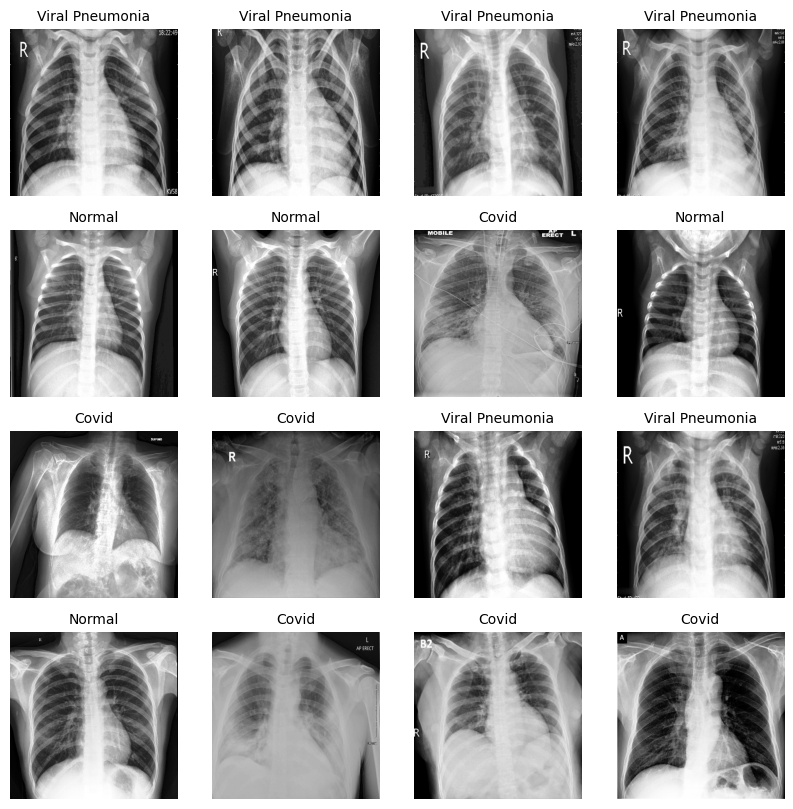

In [7]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i], fontsize=10)
    plt.axis('off')
plt.show()

# **Converting strings classes into ints**

In [39]:
class_to_index = {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
y_train_numeric = [class_to_index[label] for label in y_train]
y_train_numeric = np.array(y_train_numeric)
y_test_numeric = [class_to_index[label] for label in y_test]
y_test_numeric = np.array(y_test_numeric)


# **Model of CNN**

In [11]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(400, 400,1)))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(32, (3, 3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [12]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [13]:
batch_size = 2

history = model.fit(X_train, y_train_numeric, epochs=5, batch_size=batch_size,shuffle=True,)
model.save("COVID")

Epoch 1/5
126/126 [==============================] - 15s 18ms/step - loss: 0.8882 - accuracy: 0.7171
Epoch 2/5
126/126 [==============================] - 2s 15ms/step - loss: 0.3319 - accuracy: 0.8765
Epoch 3/5
126/126 [==============================] - 2s 14ms/step - loss: 0.2826 - accuracy: 0.8805
Epoch 4/5
126/126 [==============================] - 2s 12ms/step - loss: 0.1975 - accuracy: 0.9323
Epoch 5/5
126/126 [==============================] - 1s 10ms/step - loss: 0.0797 - accuracy: 0.9721


In [40]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 64)       0

# **Accuracy and loss plotted while training**

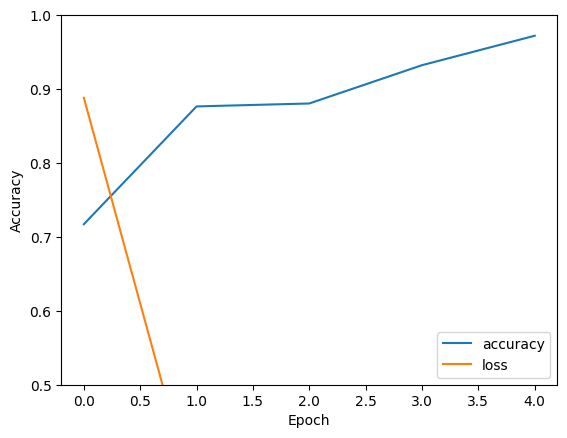

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')



In [15]:
loss, accuracy=model.evaluate(X_test,y_test_numeric)
print(f'Loss={loss}')
print(f'{accuracy * 100:.2f}%')

3/3 [==============================] - 1s 20ms/step - loss: 0.3670 - accuracy: 0.8788
Loss=0.3670083284378052
87.88%


# **Confusion matrix for test data**

3/3 [==============================] - 0s 40ms/step
tf.Tensor(
[[23  3  0]
 [ 0 20  0]
 [ 1  4 15]], shape=(3, 3), dtype=int32)


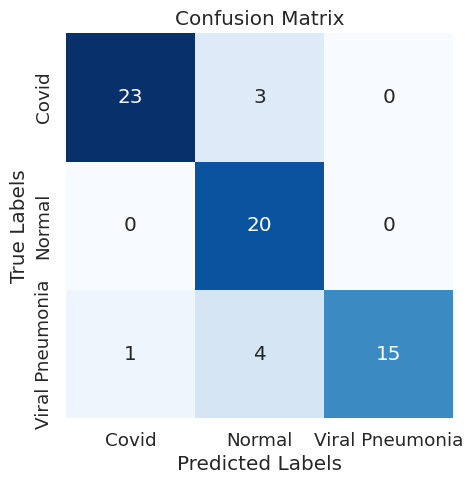

In [23]:
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)


y_test_numeric = y_test_numeric.astype(int)

confusion_matrix = tf.math.confusion_matrix(y_test_numeric, y_pred_classes)
print(confusion_matrix)


plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)

class_labels = list(class_to_index.keys())
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)


plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


# **Testing model on random picture from google**

1/1 [==============================] - 0s 64ms/step
Class is propably
Covid
With 99.8971939086914%


(-0.5, 1928.5, 2206.5, -0.5)

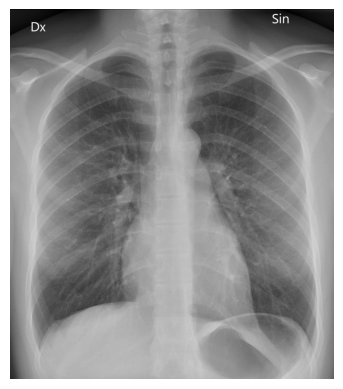

In [38]:
RTG_image = Image.open('/content/RTG.jpg').convert('L')
RTG_array = np.array(RTG_image)
normalized_image = normalize([RTG_array])
normalized_image = normalized_image.reshape((400, 400, 1))


prediction = model.predict(np.array([normalized_image]))
predicted_class = np.argmax(prediction)
confidence = prediction[0][predicted_class] * 100
print("Class is propably")
print(class_names[predicted_class])
print(f'With {confidence}%')
plt.imshow(RTG_array, cmap='gray')
plt.axis("off")